In [ ]:
#this notebook reads the experimental data from defined directories
#then a protocol of ANN optimizations is performed
#ultimately the results published in this study are obtained

In [ ]:
#executing this script without changes will load all available training sequences
#nearest neighbor Sequence information are included up to order nn=3
#however if the users memory allow nn implementation is available up to order nn=4
#then an ANN architecture has to be defined 
#the number of input channels has to be chosen adequate to the order of nn
#for nn=3 the input is SHAPE,eCLIP,SECSTRUCT + SEQUENCE(4 input channels) + nn*nnSEQUENCE(4 input channels) = 31

In [275]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import bussilab
from bussilab import ann
import scipy
from scipy.optimize import minimize

import itertools
import collections

import os

%matplotlib notebook

In [276]:
#get eCLIP dataset

data_dir='./eCLIP/'

file_names=[]
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"): 
        file_names.append(filename)
    else:
        continue

57

In [277]:
inverse_one_hot_encoding = {'A' : np.array([0,0,0,1]), 'C' : np.array([0,0,1,0]),'G': np.array([0,1,0,0]),'U': np.array([1,0,0,0])}
print(inverse_one_hot_encoding)

def inverse_mapping_bit_encode(input_array):
    output=[]
    for i,elem in enumerate(input_array):
        output.append(inverse_one_hot_encoding[elem])
    output=np.array(output)
    return output

def replace_NaNs(input_a):
    where_are_NaNs = np.isnan(input_a)
    input_a[where_are_NaNs] = 0
    input_a[where_are_NaNs] = 0
    return np.array(input_a)

eCLIP=[]
SHAPE=[]
SEQUENCE=[]

for f,file in enumerate(file_names):
    df = pd.read_csv(data_dir+file, index_col = 0, header = 0)

    eclip_event_cols = ['trun_IP1', 'mismatch_IP1', 'ins_IP1', 'del_IP1']
    eclip_event_cols2 = ['trun_IP2', 'mismatch_IP2', 'ins_IP2', 'del_IP2']

    ip1_events = df[eclip_event_cols].sum(axis = 1)
    ip2_events = df[eclip_event_cols2].sum(axis = 1)

    eCLIP.append(np.array(ip1_events+ip2_events))

    SHAPE.append(np.array(df['shape']))

    SEQUENCE.append(np.array(df['ref_seq']))

    one_hot_SEQUENCE=inverse_mapping_bit_encode(SEQUENCE[f])

    eCLIP[f]=replace_NaNs(eCLIP[f]).reshape(-1)
    SHAPE[f]=replace_NaNs(SHAPE[f]).reshape(-1)
    SEQUENCE[f]=replace_NaNs(one_hot_SEQUENCE).reshape(-1,4)


    eCLIP[f]=(eCLIP[f]-np.min(eCLIP[f])+1e-30)/(np.max(eCLIP[f])-np.min(eCLIP[f])+1e-30)

{'A': array([0, 0, 0, 1]), 'C': array([0, 0, 1, 0]), 'G': array([0, 1, 0, 0]), 'U': array([1, 0, 0, 0])}


In [278]:
struct_dir='./Structure/'
STRUCTURE=[]

for f,file in enumerate(file_names):
    file= file.replace(".csv", ".dot")
    df = pd.read_csv(struct_dir+file)
    bracket_notation=df.loc[1][0][:df.loc[1][0].find(' ')]

    #STRUCTURE 0 if ss 1 if ds
    bin_bracket_notation=[]
    for c in bracket_notation:
        if c == '.':
            bin_bracket_notation.append(0)
        else:
            bin_bracket_notation.append(1)
    STRUCTURE.append(np.array(bin_bracket_notation))

In [279]:
del_ndx=[]
for e,elem in enumerate(SEQUENCE):
    if len(elem) < 12:
        del_ndx.append(e)
             
SEQUENCE_val=[]
eCLIP_val=[]
SHAPE_val=[]
STRUCTURE_val=[]
for e,elem in enumerate(SEQUENCE):
    if e in del_ndx: 
        SEQUENCE_val.append(SEQUENCE[e])
        eCLIP_val.append(eCLIP[e])
        SHAPE_val.append(SHAPE[e])
        STRUCTURE_val.append(STRUCTURE[e])

print('eCLIP_val',len(eCLIP_val))
print('SHAPE_val',len(SHAPE_val))
print('STRUCTURE_val',len(STRUCTURE_val))
print('SEQUENCE_val',len(SEQUENCE_val))

#generate the training data
SEQUENCE=np.delete(SEQUENCE,del_ndx)
eCLIP=np.delete(eCLIP,del_ndx)
SHAPE=np.delete(SHAPE,del_ndx)
STRUCTURE=np.delete(STRUCTURE,del_ndx)


print('eCLIP',len(eCLIP))
print('SHAPE',len(SHAPE))
print('STRUCTURE',len(STRUCTURE))
print('SEQUENCE',len(SEQUENCE))

eCLIP_val 6
SHAPE_val 6
STRUCTURE_val 6
SEQUENCE_val 6
eCLIP 51
SHAPE 51
STRUCTURE 51
SEQUENCE 51


/u/t/tfrahlki/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [69]:
#up to which nearest neighbor should information be included in the fitting

nn=3

In [70]:
lneighbors=[]
rneighbors=[]
for i in range(nn):
    lneighbors.append([])
    rneighbors.append([])
    
cut_SEQUENCE=[]
cut_eCLIP=[]
cut_SHAPE=[]
cut_STRUCTURE=[]

for s,sys in enumerate(SEQUENCE):
    
    temp_lneighbors=[]
    temp_rneighbors=[]
    for i in range(nn):
        temp_lneighbors.append([])
        temp_rneighbors.append([])
    tempSEQUENCE=[]
    tempeCLIP=[]
    tempSHAPE=[]
    tempSTRUCTURE=[]
    excl_n=[]
    for i in range(nn):
        excl_n.append(i)
        excl_n.append(len(sys)-1-i)
    for n,nucl in enumerate(sys):  
        if n in excl_n:
            continue
        else:
            for i in range(nn):
                temp_lneighbors[i].append(sys[n-i-1])
                temp_rneighbors[i].append(sys[n+i+1])
            tempSEQUENCE.append(nucl)
            tempeCLIP.append(eCLIP[s][n])
            tempSHAPE.append(SHAPE[s][n])
            tempSTRUCTURE.append(STRUCTURE[s][n])
    for i in range(nn): 
        lneighbors[i].append(np.array(temp_lneighbors[i]))
        rneighbors[i].append(np.array(temp_rneighbors[i]))
    cut_SEQUENCE.append(np.array(tempSEQUENCE))
    cut_eCLIP.append(np.array(tempeCLIP))
    cut_SHAPE.append(np.array(tempSHAPE))
    cut_STRUCTURE.append(np.array(tempSTRUCTURE))

for i in range(nn):        
    lneighbors[i]=np.array(lneighbors[i],dtype=object)
    rneighbors[i]=np.array(rneighbors[i],dtype=object)
SEQUENCE=np.array(cut_SEQUENCE,dtype=object)
eCLIP=np.array(cut_eCLIP,dtype=object)
SHAPE=np.array(cut_SHAPE,dtype=object)
STRUCTURE=np.array(cut_STRUCTURE,dtype=object)

print(SEQUENCE.shape)
print(len(SEQUENCE[0]))
print(eCLIP.shape)
print(SHAPE.shape)
print(STRUCTURE.shape)
print(len(SHAPE[0]))

(51,)
19
(51,)
(51,)
(51,)
19


In [71]:
eCLIP_clipdata=np.copy(eCLIP)
SHAPE_clipdata=np.copy(SHAPE)
STRUCTURE_clipdata=np.copy(STRUCTURE)
SEQUENCE_clipdata=np.copy(SEQUENCE)

lneighbors_clipdata=np.copy(lneighbors)
rneighbors_clipdata=np.copy(rneighbors)

In [72]:
def discretizer10(input_arr):
    for s,sys in enumerate(input_arr):
        for e,elem in enumerate(sys):
            #print(elem)
            if elem >= 0 and elem < 0.1:
                input_arr[s][e]=0.0
            if elem >= 0.1 and elem < 0.2:
                input_arr[s][e]=0.1
            if elem >= 0.2 and elem < 0.3:
                input_arr[s][e]=0.2
            if elem >= 0.3 and elem < 0.4:
                input_arr[s][e]=0.3
            if elem >= 0.4 and elem < 0.5:
                input_arr[s][e]=0.4
            if elem >= 0.5 and elem < 0.6:
                input_arr[s][e]=0.5
            if elem >= 0.6 and elem < 0.7:
                input_arr[s][e]=0.6
            if elem >= 0.7 and elem < 0.8:
                input_arr[s][e]=0.7
            if elem >= 0.8 and elem < 0.9:
                input_arr[s][e]=0.8
            if elem >= 0.9 and elem <= 1.0:
                input_arr[s][e]=0.9
                
    return input_arr

def discretizer2(input_arr):
    for s,sys in enumerate(input_arr):
        for e,elem in enumerate(sys):
            if elem < 0.5:
                input_arr[s][e]=int(0)
            if elem >= 0.5:
                input_arr[s][e]=int(1)
                
    return input_arr

def discretizer3(input_arr):
    for s,sys in enumerate(input_arr):
        for e,elem in enumerate(sys):
            if elem >= 0 and elem < 0.3:
                input_arr[s][e]=0.0
            if elem >= 0.3 and elem < 0.7:
                input_arr[s][e]=0.5
            if elem >= 0.7 and elem <= 1:
                input_arr[s][e]=1.0
                
    return input_arr

eCLIP_clipdata=discretizer3(eCLIP_clipdata) #discretizer2(eCLIP_clipdata) #discretizer10(eCLIP_clipdata) #
SHAPE_clipdata=discretizer3(SHAPE_clipdata) #discretizer2(SHAPE_clipdata) #discretizer10(SHAPE_clipdata) #

eCLIP_val=discretizer3(eCLIP_val) #discretizer2(eCLIP_val) #discretizer10(eCLIP_val) #
SHAPE_val=discretizer3(SHAPE_val) #discretizer2(SHAPE_val) #discretizer10(SHAPE_val) #

print(eCLIP_clipdata.shape)
print(SHAPE_clipdata.shape)
print(STRUCTURE_clipdata.shape)
print(SEQUENCE_clipdata.shape)
for i in range(nn):  
    print(lneighbors_clipdata[i].shape)
    print(rneighbors_clipdata[i].shape)

(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)


In [74]:
#eCLIP_partitionF=[0,1]
#SHAPE_partitionF=[0,1]
eCLIP_partitionF=[0,0.5,1]
SHAPE_partitionF=[0,0.5,1]
#eCLIP_partitionF=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#SHAPE_partitionF=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
STRUCTURE_partitionF=[0,1]
SEQUENCE_partitionF=[[0, 0, 0, 1],[0, 0, 1, 0],[0, 1, 0, 0],[1, 0, 0, 0]]

lneighbors_partitionF=[]
rneighbors_partitionF=[]

for i in range(nn):  
    lneighbors_partitionF.append([[0, 0, 0, 1],[0, 0, 1, 0],[0, 1, 0, 0],[1, 0, 0, 0]])
    rneighbors_partitionF.append([[0, 0, 0, 1],[0, 0, 1, 0],[0, 1, 0, 0],[1, 0, 0, 0]])

obs_input=[]
obs_input.append(eCLIP_partitionF)
obs_input.append(SHAPE_partitionF)
obs_input.append(STRUCTURE_partitionF)
obs_input.append(SEQUENCE_partitionF)
for i in range(nn):
    obs_input.append(lneighbors_partitionF[i])
    obs_input.append(rneighbors_partitionF[i])

print('start generating')
partitions_traj=[x for x in itertools.product(*obs_input)]

partitions_traj=np.array(partitions_traj,dtype=object)
eCLIP_all_states=[partitions_traj[:,0]]
SHAPE_all_states=[partitions_traj[:,1]]
STRUCTURE_all_states=[partitions_traj[:,2]]
SEQUENCE_all_states=[]
lneighbors_all_states=[]
rneighbors_all_states=[]
for i in range(nn):
    lneighbors_all_states.append([])
    rneighbors_all_states.append([])
for e,elem in enumerate(partitions_traj[:,3]):
    SEQUENCE_all_states.append(list(elem))
    
    for i in range(nn):
        lneighbors_all_states[i].append(list(partitions_traj[e,4+i*2]))
        rneighbors_all_states[i].append(list(partitions_traj[e,5+i*2]))
        
SEQUENCE_all_states=[np.array(SEQUENCE_all_states)]

for i in range(nn):
    lneighbors_all_states[i]=[np.array(lneighbors_all_states[i])]
    rneighbors_all_states[i]=[np.array(rneighbors_all_states[i])]

start generating
294912
294912
294912
294912
294912
294912
294912
(294912, 10)


In [75]:
np.save('./RBPNet_saves/eCLIP_partition_%s.npy' %nn,eCLIP_all_states)
np.save('./RBPNet_saves/SHAPE_partition_%s.npy' %nn,SHAPE_all_states)
np.save('./RBPNet_saves/STRUCTURE_partition_%s.npy' %nn,STRUCTURE_all_states)
np.save('./RBPNet_saves/SEQUENCE_partition_%s.npy' %nn,SEQUENCE_all_states)
np.save('./RBPNet_saves/lneighbors_partition_%s.npy' %nn,lneighbors_all_states)
np.save('./RBPNet_saves/rneighbors_partition_%s.npy' %nn,rneighbors_all_states)

In [76]:
partition_input_data=[]

partition_input_data.append(eCLIP_all_states[0])
partition_input_data.append(SHAPE_all_states[0])
partition_input_data.append(STRUCTURE_all_states[0])
partition_input_data.append(SEQUENCE_all_states[0][:,0])
partition_input_data.append(SEQUENCE_all_states[0][:,1])
partition_input_data.append(SEQUENCE_all_states[0][:,2])
partition_input_data.append(SEQUENCE_all_states[0][:,3])
for i in range(nn):
    partition_input_data.append(lneighbors_all_states[i][0][:,0])
    partition_input_data.append(lneighbors_all_states[i][0][:,1])
    partition_input_data.append(lneighbors_all_states[i][0][:,2])
    partition_input_data.append(lneighbors_all_states[i][0][:,3])
    partition_input_data.append(rneighbors_all_states[i][0][:,0])
    partition_input_data.append(rneighbors_all_states[i][0][:,1])
    partition_input_data.append(rneighbors_all_states[i][0][:,2])
    partition_input_data.append(rneighbors_all_states[i][0][:,3])

partition_input_data=np.array(partition_input_data)
print(partition_input_data.shape)

np.save('./RBPNet_saves/partition_input_data_%s.npy' %nn,partition_input_data)

(31, 294912)


In [77]:
eCLIP_all_states=np.load('./RBPNet_saves/eCLIP_partition_%s.npy' %nn,allow_pickle=True)
SHAPE_all_states=np.load('./RBPNet_saves/SHAPE_partition_%s.npy' %nn,allow_pickle=True)
STRUCTURE_all_states=np.load('./RBPNet_saves/STRUCTURE_partition_%s.npy' %nn,allow_pickle=True)
SEQUENCE_all_states=np.load('./RBPNet_saves/SEQUENCE_partition_%s.npy' %nn,allow_pickle=True)
lneighbors_all_states=np.load('./RBPNet_saves/lneighbors_partition_%s.npy' %nn,allow_pickle=True)
rneighbors_all_states=np.load('./RBPNet_saves/rneighbors_partition_%s.npy' %nn,allow_pickle=True)
partition_input_data=np.load('./RBPNet_saves/partition_input_data_%s.npy' %nn,allow_pickle=True)

In [78]:
def _logsum(ns):
    max = np.max(ns)
    ds = ns - max
    sumOfExp = np.exp(ds).sum()
    return max + np.log(sumOfExp)

def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [79]:
#define the training dataset
eCLIP=eCLIP_clipdata
SHAPE=SHAPE_clipdata
STRUCTURE=STRUCTURE_clipdata
SEQUENCE=SEQUENCE_clipdata 

lneighbors=lneighbors_clipdata 
rneighbors=rneighbors_clipdata 

nsys=len(eCLIP)   

all_states=partition_input_data.T.tolist()

ndx_list_collector=[]
for s in range(nsys):
    input_data=[]
    input_data.append(eCLIP[s])
    input_data.append(SHAPE[s])
    input_data.append(STRUCTURE[s])
    input_data.append(SEQUENCE[s][:,0])
    input_data.append(SEQUENCE[s][:,1])
    input_data.append(SEQUENCE[s][:,2])
    input_data.append(SEQUENCE[s][:,3])
    for i in range(nn):
        input_data.append(lneighbors[i][s][:,0])
        input_data.append(lneighbors[i][s][:,1])
        input_data.append(lneighbors[i][s][:,2])
        input_data.append(lneighbors[i][s][:,3])
        input_data.append(rneighbors[i][s][:,0])
        input_data.append(rneighbors[i][s][:,1])
        input_data.append(rneighbors[i][s][:,2])
        input_data.append(rneighbors[i][s][:,3])
    

    input_data= np.array(input_data)
        
    index=[]
    for n,nucleo in enumerate(eCLIP[s]):
        check=input_data[:,n].tolist()
        index.append(all_states.index(check))
    ndx_list_collector.append(index)

51


In [80]:
d_U=[]
for s in range(len(ndx_list_collector)):
    d_U.append(np.zeros(len(eCLIP_all_states[0])))
    for i in ndx_list_collector[s]:
        d_U[s][i]+=1
    d_U[s]/=np.sum(d_U[s])

In [81]:
eps=1e-30

def cost_function(par,regularize=True):

    assert(len(par)==npar)
    RBP_net.setpar(par)
    
    cost=0
    derivatives=np.zeros(npar)
       
            
    for s in range(considered_sys):
            partition_func_net=RBP_net.forward(partition_input_data.T)
            u=partition_func_net.f.asarray()[:,0]

            Z=_logsum(-u)
            d_Z=-_softmax(-u)


            cost+=np.dot(u,d_U[s]) + Z
            d_cost=d_U[s]+d_Z

            derivatives+=RBP_net.backward_par(d_cost,partition_func_net)
    
    track_cost.append(cost)
    
    return cost,derivatives

133 128
b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT' False 593.4648980995357
[-0.02648761  0.70714974  0.40212169  0.03234627  0.01640664  0.63128541
  0.26361202 -0.06614295 -0.29178659  0.43189481  0.04918288 -0.25114227
  0.40021104  0.26952173  0.05954336  0.38985725  0.04939957  0.40019074
  0.18805692  0.31084747 -0.05114407  0.58033043  0.25918682  0.1277069
  0.43413315  0.40096927  0.02688745  0.23149509  0.46045523  0.26946172
  0.07296111  0.35725463  0.04679472  0.44604473  0.05782751  0.32837331
 -0.03018809  0.57307649  0.16722573  0.18609257  0.29727812  0.45688263
  0.22208339  0.21326792  0.23238238  0.32061885  0.15643062  0.39847452
  0.25571684  0.34872829  0.04115671  0.27859144  0.23155263  0.3367235
  0.19476288  0.2675049   0.02969335  0.6727348   0.11517942  0.12665533
  0.41638514  0.26492928  0.07956523  0.36114046  0.01584418  0.6068674
  0.0857661   0.08010515  0.3229279   0.21314087  0.18337045  0.35858892
  0.09839404  0.53357676  0.18319885  0

<IPython.core.display.Javascript object>


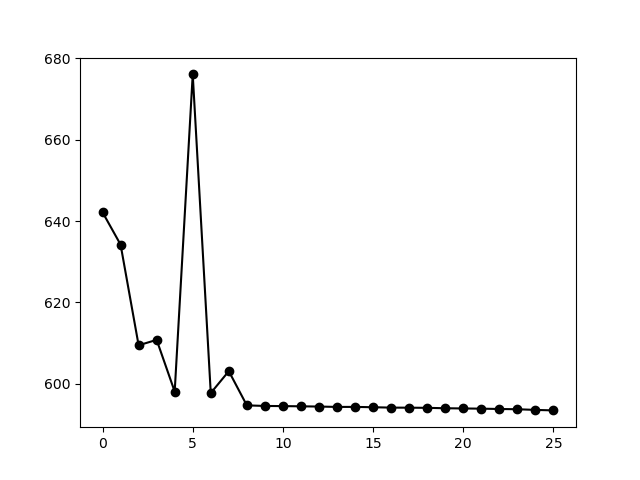

In [19]:
track_cost=[]

considered_sys=len(ndx_list_collector)
#build ANN
use_cuda=True
layers=[31,4] # architecture: 31 input nodes, 4 hidden nodes, 1 output
RBP_net=ann.ANN(random_weights=True,layers=layers,cuda=use_cuda)
npar=RBP_net.npar
nweights=RBP_net.nparW
print(npar,nweights)    
    
np.random.seed(1995)
starting_input=np.random.uniform(size=(npar))*0.1
NeuralNetworks_m=minimize(cost_function,x0=starting_input,method='L-BFGS-B',jac=True,options={'maxfun': 25})
print(NeuralNetworks_m.message,NeuralNetworks_m.success,NeuralNetworks_m.fun)
print(NeuralNetworks_m.x)

#this plot should show a convergence of the error quantity the ANN is trained on
plt.figure()
plt.plot(track_cost,'o-',color='black')
plt.show()

In [35]:
#this cell evaluates the trained network on the training data
#this way the probabilities for each state are available

count_prob=[]
for s in range(len(ndx_list_collector)):
    count_prob.append(np.zeros(len(eCLIP_all_states[0])))
    for i in ndx_list_collector[s]:
        count_prob[s][i]+=1
        
ave_dU=np.sum(count_prob,axis=0)
ave_dU/=np.sum(ave_dU)
ave_dU[np.where(ave_dU==0)]=1e-30

partition_func_net=RBP_net.forward(partition_input_data.T)
u_tot=partition_func_net.f.asarray()[:,0]


probability=_softmax(-u_tot)
F=-np.log(probability)

In [40]:
n=1000
ind_histo = np.argsort(ave_dU)[::-1]
sorted_ave_dU = ave_dU[ind_histo]
topn_histo = sorted_ave_dU[:n]
topn_ind_histo = ind_histo[:n]

In [41]:
ind_prob = np.argsort(probability)[::-1]
sorted_probability = probability[ind_prob]
topn_prob = sorted_probability[:n]
topn_ind_prob = ind_prob[:n]

In [42]:
one_hot_encoding = {str(np.array([0,0,0,1])): 'A', str(np.array([0,0,1,0])): 'C',str(np.array([0,1,0,0])): 'G',str(np.array([1,0,0,0])): 'U'}

def also_mapping_bit_encode(input_array):
    output=[]
    for e in input_array:
        #print(e)
        output.append((one_hot_encoding[np.array_str(e)]))
    output=np.array(output)
    return output

top_motifs_histo=[]
top_motifs_prob=[]
for s in range(2):
    if s==0:
        index=topn_ind_histo 
    else:
        index=topn_ind_prob 
        
    for elem in range(len(index)):
        c=partition_input_data[3:7,index[elem]].T
        if nn >=0:
            letter_SEQUENCE=also_mapping_bit_encode(np.array([c]))
        if nn >=1:
            l=partition_input_data[7:11,index[elem]].T
            r=partition_input_data[11:15,index[elem]].T
            letter_SEQUENCE=also_mapping_bit_encode(np.array([l,c,r]))
        if nn >=2:
            ll=partition_input_data[15:19,index[elem]].T
            rr=partition_input_data[19:23,index[elem]].T
            letter_SEQUENCE=also_mapping_bit_encode(np.array([ll,l,c,r,rr]))
        if nn >=3:
            lll=partition_input_data[23:27,index[elem]].T
            rrr=partition_input_data[27:31,index[elem]].T
            letter_SEQUENCE=also_mapping_bit_encode(np.array([lll,ll,l,c,r,rr,rrr]))
        if nn >=4:
            llll=partition_input_data[31:35,index[elem]].T
            rrrr=partition_input_data[35:39,index[elem]].T
            letter_SEQUENCE=also_mapping_bit_encode(np.array([llll,lll,ll,l,c,r,rr,rrr,rrrr]))

        if s==0:
            top_motifs_histo.append(letter_SEQUENCE)
        else:
            top_motifs_prob.append(letter_SEQUENCE)

In [43]:
for i in range(10):
    print(i,top_motifs_histo[i],topn_histo[i]*100,top_motifs_prob[i],topn_prob[i]*100)

0 ['G' 'A' 'G' 'A' 'G' 'A' 'G'] 0.22036139268400176 ['C' 'G' 'G' 'G' 'G' 'G' 'G'] 0.006295003549894318
1 ['C' 'C' 'U' 'C' 'C' 'C' 'A'] 0.17628911414720141 ['C' 'G' 'G' 'C' 'G' 'G' 'G'] 0.006267891149036586
2 ['G' 'G' 'C' 'C' 'C' 'C' 'U'] 0.17628911414720141 ['C' 'G' 'C' 'G' 'G' 'G' 'G'] 0.006239752110559493
3 ['U' 'U' 'U' 'U' 'U' 'U' 'U'] 0.13221683561040104 ['G' 'G' 'G' 'G' 'G' 'G' 'G'] 0.006234054308151826
4 ['A' 'G' 'G' 'U' 'C' 'G' 'G'] 0.13221683561040104 ['C' 'G' 'G' 'G' 'G' 'G' 'C'] 0.006178112380439416
5 ['C' 'G' 'G' 'C' 'G' 'C' 'C'] 0.13221683561040104 ['C' 'G' 'G' 'G' 'C' 'G' 'G'] 0.0061538499721791595
6 ['C' 'U' 'C' 'C' 'C' 'A' 'C'] 0.13221683561040104 ['C' 'G' 'C' 'C' 'G' 'G' 'G'] 0.00615320386714302
7 ['C' 'A' 'G' 'C' 'C' 'U' 'G'] 0.13221683561040104 ['G' 'G' 'G' 'C' 'G' 'G' 'G'] 0.006151584966573864
8 ['G' 'C' 'G' 'G' 'C' 'G' 'G'] 0.13221683561040104 ['G' 'G' 'C' 'G' 'G' 'G' 'G'] 0.006148429383756593
9 ['U' 'U' 'C' 'G' 'G' 'C' 'U'] 0.13221683561040104 ['G' 'G' 'G' 'G' 'C' 

In [44]:
for i in range(10):
    print(i,top_motifs_histo[i],top_motifs_prob[i])

0 ['G' 'A' 'G' 'A' 'G' 'A' 'G'] ['C' 'G' 'G' 'G' 'G' 'G' 'G']
1 ['C' 'C' 'U' 'C' 'C' 'C' 'A'] ['C' 'G' 'G' 'C' 'G' 'G' 'G']
2 ['G' 'G' 'C' 'C' 'C' 'C' 'U'] ['C' 'G' 'C' 'G' 'G' 'G' 'G']
3 ['U' 'U' 'U' 'U' 'U' 'U' 'U'] ['G' 'G' 'G' 'G' 'G' 'G' 'G']
4 ['A' 'G' 'G' 'U' 'C' 'G' 'G'] ['C' 'G' 'G' 'G' 'G' 'G' 'C']
5 ['C' 'G' 'G' 'C' 'G' 'C' 'C'] ['C' 'G' 'G' 'G' 'C' 'G' 'G']
6 ['C' 'U' 'C' 'C' 'C' 'A' 'C'] ['C' 'G' 'C' 'C' 'G' 'G' 'G']
7 ['C' 'A' 'G' 'C' 'C' 'U' 'G'] ['G' 'G' 'G' 'C' 'G' 'G' 'G']
8 ['G' 'C' 'G' 'G' 'C' 'G' 'G'] ['G' 'G' 'C' 'G' 'G' 'G' 'G']
9 ['U' 'U' 'C' 'G' 'G' 'C' 'U'] ['G' 'G' 'G' 'G' 'C' 'G' 'G']


In [45]:
#now one could also ask what are the most probable motifs with a central A?

counter1=0
counter2=0
histo_motifs_top10=[]
prob_motifs_top10=[]
for i in range(len(topn_ind_histo)):
    if top_motifs_histo[i][nn] == 'A':
        if counter1 <20:
            histo_motifs_top10.append([i,top_motifs_histo[i],topn_histo[i]*100])
            counter1+=1
    if top_motifs_prob[i][nn] == 'A':
        if counter2 <20:
            prob_motifs_top10.append([i,top_motifs_prob[i],topn_prob[i]*100])
            counter2+=1

In [46]:
for i in range(len(histo_motifs_top10)):
    print(i,histo_motifs_top10[i][0],histo_motifs_top10[i][1],histo_motifs_top10[i][2])

0 0 ['G' 'A' 'G' 'A' 'G' 'A' 'G'] 0.22036139268400176
1 17 ['U' 'C' 'G' 'A' 'G' 'U' 'G'] 0.13221683561040104
2 26 ['G' 'U' 'G' 'A' 'G' 'C' 'C'] 0.08814455707360071
3 41 ['C' 'U' 'C' 'A' 'C' 'A' 'C'] 0.08814455707360071
4 42 ['U' 'G' 'G' 'A' 'G' 'U' 'U'] 0.08814455707360071
5 67 ['C' 'U' 'G' 'A' 'G' 'G' 'C'] 0.08814455707360071
6 76 ['G' 'C' 'C' 'A' 'G' 'C' 'C'] 0.08814455707360071
7 95 ['U' 'G' 'G' 'A' 'G' 'A' 'G'] 0.08814455707360071
8 104 ['U' 'G' 'G' 'A' 'G' 'G' 'U'] 0.08814455707360071
9 113 ['C' 'G' 'G' 'A' 'G' 'G' 'C'] 0.08814455707360071
10 117 ['G' 'A' 'G' 'A' 'G' 'G' 'U'] 0.08814455707360071
11 118 ['G' 'A' 'C' 'A' 'G' 'A' 'G'] 0.08814455707360071
12 119 ['G' 'G' 'C' 'A' 'A' 'C' 'U'] 0.08814455707360071
13 123 ['A' 'G' 'G' 'A' 'U' 'G' 'G'] 0.044072278536800354
14 127 ['G' 'A' 'C' 'A' 'G' 'C' 'A'] 0.044072278536800354
15 128 ['C' 'A' 'A' 'A' 'G' 'G' 'G'] 0.044072278536800354
16 132 ['A' 'G' 'C' 'A' 'A' 'U' 'A'] 0.044072278536800354
17 139 ['G' 'G' 'G' 'A' 'C' 'C' 'G'] 0.0440722

In [254]:
count_prob=[]
for s in range(len(ndx_list_collector)):
    count_prob.append(np.zeros(len(eCLIP_all_states[0])))
    for i in ndx_list_collector[s]:
        count_prob[s][i]+=1
        
ave_dU=np.sum(count_prob,axis=0)
ave_dU/=np.sum(ave_dU)
ave_dU[np.where(ave_dU==0)]=1e-8 

partition_func_net=RBP_net.forward(partition_input_data.T)
u_tot=partition_func_net.f.asarray()[:,0]

probability=_softmax(-u_tot)
F=-np.log(probability)

In [255]:
#next would be which are the most probable motifs with high eCLIP low SHAPE
#and which are the ones with a central A
#all under the assumption that such a combination corresponds to an RBP site

#define and index based on those criteria and do

conditional_ndx=np.where((partition_input_data[0,:]>=0.7) &(partition_input_data[1,:]<=0.3) &(partition_input_data[2,:]==0) )
ave_dU=ave_dU[conditional_ndx]
probability=probability[conditional_ndx]

n=int(ave_dU.shape[0]/10) #5000
ind_histo = np.argsort(ave_dU)[::-1]
sorted_ave_dU = ave_dU[ind_histo]
topn_histo = sorted_ave_dU[:n]
topn_ind_histo = ind_histo[:n]

In [257]:
ind_prob = np.argsort(probability)[::-1]
sorted_probability = probability[ind_prob]
topn_prob = sorted_probability[:n]
topn_ind_prob = ind_prob[:n]

In [258]:
top_motifs_histo=[]
top_motifs_prob=[]
for s in range(2):
    if s==0:
        index=topn_ind_histo 
    else:
        index=topn_ind_prob 
        
    for elem in range(len(index)):
        c=partition_input_data[3:7,index[elem]].T
        if nn ==0:
            letter_SEQUENCE=also_mapping_bit_encode(np.array([c]))
        if nn ==1:
            l=partition_input_data[7:11,index[elem]].T
            r=partition_input_data[11:15,index[elem]].T
            letter_SEQUENCE=also_mapping_bit_encode(np.array([l,c,r]))
        if nn ==2:
            ll=partition_input_data[15:19,index[elem]].T
            rr=partition_input_data[19:23,index[elem]].T
            letter_SEQUENCE=also_mapping_bit_encode(np.array([ll,l,c,r,rr]))
        if nn ==3:
            lll=partition_input_data[23:27,index[elem]].T
            rrr=partition_input_data[27:31,index[elem]].T
            letter_SEQUENCE=also_mapping_bit_encode(np.array([lll,ll,l,c,r,rr,rrr]))
        if nn ==4:
            llll=partition_input_data[31:35,index[elem]].T
            rrrr=partition_input_data[35:39,index[elem]].T
            letter_SEQUENCE=also_mapping_bit_encode(np.array([llll,lll,ll,l,c,r,rr,rrr,rrrr]))

        if s==0:
            top_motifs_histo.append(letter_SEQUENCE)
        else:
            top_motifs_prob.append(letter_SEQUENCE)

In [259]:
#now one could also ask what are the most probable motifs with a central A?

counter1=0
counter2=0
histo_motifs_top10=[]
prob_motifs_top10=[]
for i in range(len(topn_ind_histo)):
    if top_motifs_histo[i][nn] == 'A':
        if counter1 <20:
            histo_motifs_top10.append([i,top_motifs_histo[i],topn_histo[i]*100])
            counter1+=1
    if top_motifs_prob[i][nn] == 'A':
        if counter2 <20:
            prob_motifs_top10.append([i,top_motifs_prob[i],topn_prob[i]*100])
            counter2+=1

In [260]:
for i in range(len(histo_motifs_top10)):
    print(i,histo_motifs_top10[i][0],histo_motifs_top10[i][1],histo_motifs_top10[i][2])

0 1 ['C' 'G' 'C' 'A' 'G' 'C' 'G'] 0.044072278536800354
1 4 ['G' 'G' 'C' 'A' 'G' 'C' 'G'] 0.044072278536800354
2 10 ['A' 'G' 'C' 'A' 'G' 'C' 'G'] 0.044072278536800354
3 13 ['C' 'G' 'C' 'A' 'G' 'C' 'G'] 0.044072278536800354
4 14 ['A' 'G' 'C' 'A' 'G' 'C' 'A'] 0.044072278536800354
5 16 ['U' 'G' 'C' 'A' 'G' 'C' 'A'] 0.044072278536800354
6 17 ['C' 'G' 'C' 'A' 'G' 'C' 'C'] 0.044072278536800354
7 21 ['A' 'G' 'C' 'A' 'G' 'C' 'A'] 0.044072278536800354
8 22 ['G' 'G' 'C' 'A' 'G' 'C' 'G'] 0.044072278536800354
9 24 ['U' 'G' 'C' 'A' 'G' 'C' 'C'] 0.044072278536800354
10 30 ['G' 'G' 'C' 'A' 'G' 'C' 'A'] 0.044072278536800354
11 32 ['C' 'G' 'C' 'A' 'G' 'C' 'G'] 0.044072278536800354


In [261]:
for i in range(len(prob_motifs_top10)):
    print(i,prob_motifs_top10[i][0],prob_motifs_top10[i][1],prob_motifs_top10[i][2])

0 211 ['C' 'G' 'C' 'A' 'G' 'C' 'G'] 0.00023182406039268244
1 214 ['G' 'G' 'C' 'A' 'G' 'C' 'G'] 0.00023148650143411942
2 239 ['C' 'G' 'C' 'A' 'G' 'C' 'G'] 0.00022891617845743895
3 258 ['G' 'G' 'C' 'A' 'G' 'C' 'G'] 0.00022756926227884833
4 285 ['G' 'G' 'C' 'A' 'G' 'C' 'G'] 0.0002256037305414793
5 287 ['C' 'G' 'C' 'A' 'G' 'C' 'C'] 0.00022556239400728373
6 294 ['C' 'G' 'C' 'A' 'G' 'C' 'G'] 0.00022512485884362832
7 299 ['G' 'G' 'C' 'A' 'G' 'C' 'C'] 0.0002248399368909304
8 347 ['C' 'G' 'C' 'A' 'G' 'C' 'G'] 0.0002213346760981949
9 361 ['G' 'G' 'C' 'A' 'G' 'C' 'G'] 0.00022074698335927678
10 378 ['C' 'G' 'C' 'A' 'G' 'C' 'C'] 0.00021977734832034912
11 411 ['G' 'G' 'C' 'A' 'G' 'C' 'C'] 0.00021780931547255022
12 413 ['G' 'G' 'C' 'A' 'G' 'C' 'G'] 0.00021763655695394846
13 432 ['C' 'G' 'C' 'A' 'G' 'C' 'C'] 0.00021682114947907394
14 435 ['G' 'G' 'C' 'A' 'G' 'C' 'C'] 0.0002167351567550213
15 469 ['C' 'G' 'C' 'A' 'G' 'C' 'G'] 0.00021498615296877688
16 471 ['G' 'G' 'C' 'A' 'G' 'C' 'G'] 0.000214904162021

In [262]:
gen_input=[]
gen_input.append(SEQUENCE_partitionF)
for i in range(nn):
    gen_input.append(lneighbors_partitionF[i])
    gen_input.append(rneighbors_partitionF[i])

print('start generating')
all_sequences=[x for x in itertools.product(*gen_input)]
all_sequences=np.array(all_sequences,dtype=object)

start generating


In [264]:
one_hot_encoding = {str(np.array([0,0,0,1])): 'A', str(np.array([0,0,1,0])): 'C',str(np.array([0,1,0,0])): 'G',str(np.array([1,0,0,0])): 'U'}

def also_mapping_bit_encode(input_array):
    output=[]
    for e in input_array:
        #print(e)
        output.append((one_hot_encoding[np.array_str(e)]))
    output=np.array(output)
    return output

seq_str=[]
for i in range(all_sequences.shape[0]):
    letter_SEQUENCE=also_mapping_bit_encode(all_sequences[i,:,:])
    seq_str.append(letter_SEQUENCE)


In [265]:
seq_str=np.array(seq_str)
seq_str.shape

(16384, 7)

In [266]:
s_dir='./RBPNet_saves/'

In [267]:
with open(s_dir+'All_combinations_sites%s.txt'%nn, 'w') as f:
    for i in range(len(seq_str)):
        f.write(''.join(seq_str[i])+'\n')

In [268]:
prob_motifs_top10perc=[]
for i in range(len(topn_ind_histo)):
    
    if top_motifs_prob[i][nn] == 'A':
        prob_motifs_top10perc.append(top_motifs_prob[i])

In [269]:
#extract most probable sequences with a central A

with open(s_dir+'RBP_sites%s.txt'%nn, 'w') as f:
    for i in range(len(prob_motifs_top10perc)):
        f.write(''.join(prob_motifs_top10perc[i])+'\n')

In [ ]:
#to create the visualization of the RBP site sequence properties using All_combinations_sites*.txt and RBP_sites*.txt:
#http://www.twosamplelogo.org

In [287]:
#validation sequences

#Neil1
val_seq='CCUGCCCUCUGAUCUCUGCCUGUUCCUCUGUCCCACAGGGGGCAAAGGCUACGGGUCAGAGAGCGGGGAGGAGG'
val_struct='(((.(((.(.(.((((((((.((.(((.((((((....)))))).)))..)).)).)))))).).).).)))))'


#BDF2
#val_seq='UUCCCCACUUGUCAUUAGACGUUCAGUUAGUACCACCAAUGACAAUAUUGGGGAA'
#val_struct='(((((((.((((((((.(..((.(.....).))..).))))))))...)))))))'

#hGLI1
#val_seq='UCUGUCUACUCACCACAGCCCCCCAGCAUCACUGAGAAUGCUGCCAUGGAUGCUAGAGGGCUACAGGAAGAGCCAGA'
#val_struct='((((.((..((.....(((((.(.((((((..((..........))..)))))).).)))))....))..)).))))'


#from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3226063/
#pri-miR
#val_seq='UUUGGUAUUUAAAAGGUAGAUUCUCCUUCUAUGAGUACAUUAUUUAUGAUUAAUCAUAGAGGAAAAUCCACGUUUUCAGUAUCAAA'
#val_struct='((((.((.(.((((.((.((((.((((.((((((...(((.....))),,,,,)))))))))),)))),)),)))),),)),))))'




bin_bracket_notation=[]
for c in val_struct:
    if c == '.':
        bin_bracket_notation.append(0)
    else:
        bin_bracket_notation.append(1)


SEQUENCEletter=val_seq
Sequence=inverse_mapping_bit_encode(val_seq)
structure=np.array(bin_bracket_notation)
print(len(SEQUENCEletter))
print(Sequence.shape)
print(structure.shape)

#have a sequence information for nn=4
LNextNextNextNeighbor=Sequence[:-8]
RNextNextNextNeighbor=Sequence[8:]

#have a sequence information for nn=3
LNextNextNeighbor=Sequence[1:-7]
RNextNextNeighbor=Sequence[7:-1]

#have a sequence information for nn=2
LNextNeighbor=Sequence[2:-6]
RNextNeighbor=Sequence[6:-2]

#have a sequence information for nn=1
Lneighbor=Sequence[3:-5]
Rneighbor=Sequence[5:-3]

#cut the Sequence input for the central nucleotide into the right format according to the list created above L,R neighbors
SEQUENCEletter=SEQUENCEletter[4:-4]
Sequence=Sequence[4:-4]
structure=structure[4:-4]


print(len(SEQUENCEletter))
print(Sequence.shape)
print(structure.shape)
print(Lneighbor.shape)
print(Rneighbor.shape)
print(LNextNeighbor.shape)
print(RNextNeighbor.shape)
print(LNextNextNeighbor.shape)
print(RNextNextNeighbor.shape)

74
(74, 4)
(74,)
66
(66, 4)
(66,)
(66, 4)
(66, 4)
(66, 4)
(66, 4)
(66, 4)
(66, 4)


In [285]:
params=NeuralNetworks_m.x


seq_P_cond=[]
for s,seq in enumerate(Sequence[:]):
    P=[]
    ndx=0
    ndx_cond=[]
    for ec in [0,0.5,1]:#[0,1]:#[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        for n in [0,0.5,1]:#[0,1]:#[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
            eCLIP=np.array([ec])
            SHAPE=np.array([n])
            STRUCTURE=np.array([structure[s]])
            SEQUENCE=np.array([seq]) #[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]
            LNNEIGHBOR=np.array([Lneighbor[s]])
            RNNEIGHBOR=np.array([Rneighbor[s]])
            LNextNNEIGHBOR=np.array([LNextNeighbor[s]])
            RNextNNEIGHBOR=np.array([RNextNeighbor[s]])
            LNextNextNNEIGHBOR=np.array([LNextNextNeighbor[s]])
            RNextNextNNEIGHBOR=np.array([RNextNextNeighbor[s]])
            L3NNEIGHBOR=np.array([LNextNextNextNeighbor[s]])
            R3NNEIGHBOR=np.array([RNextNextNextNeighbor[s]])

            RBP_net.setpar(params)

            #nn=1
            #input_data= np.array([eCLIP,SHAPE,STRUCTURE,SEQUENCE[:,0],SEQUENCE[:,1],SEQUENCE[:,2],SEQUENCE[:,3],
            #                      LNNEIGHBOR[:,0],LNNEIGHBOR[:,1],LNNEIGHBOR[:,2],LNNEIGHBOR[:,3],
            #                      RNNEIGHBOR[:,0],RNNEIGHBOR[:,1],RNNEIGHBOR[:,2],RNNEIGHBOR[:,3]])

            #nn=2
            #input_data= np.array([eCLIP,SHAPE,STRUCTURE,SEQUENCE[:,0],SEQUENCE[:,1],SEQUENCE[:,2],SEQUENCE[:,3],
            #                      LNNEIGHBOR[:,0],LNNEIGHBOR[:,1],LNNEIGHBOR[:,2],LNNEIGHBOR[:,3],
            #                      RNNEIGHBOR[:,0],RNNEIGHBOR[:,1],RNNEIGHBOR[:,2],RNNEIGHBOR[:,3],
            #                      LNextNNEIGHBOR[:,0],LNextNNEIGHBOR[:,1],LNextNNEIGHBOR[:,2],LNextNNEIGHBOR[:,3],
            #                      RNextNNEIGHBOR[:,0],RNextNNEIGHBOR[:,1],RNextNNEIGHBOR[:,2],RNextNNEIGHBOR[:,3]])

            #nn=3
            input_data= np.array([eCLIP,SHAPE,STRUCTURE,SEQUENCE[:,0],SEQUENCE[:,1],SEQUENCE[:,2],SEQUENCE[:,3],
                                  LNNEIGHBOR[:,0],LNNEIGHBOR[:,1],LNNEIGHBOR[:,2],LNNEIGHBOR[:,3],
                                  RNNEIGHBOR[:,0],RNNEIGHBOR[:,1],RNNEIGHBOR[:,2],RNNEIGHBOR[:,3],
                                  LNextNNEIGHBOR[:,0],LNextNNEIGHBOR[:,1],LNextNNEIGHBOR[:,2],LNextNNEIGHBOR[:,3],
                                  RNextNNEIGHBOR[:,0],RNextNNEIGHBOR[:,1],RNextNNEIGHBOR[:,2],RNextNNEIGHBOR[:,3],
                                  LNextNextNNEIGHBOR[:,0],LNextNextNNEIGHBOR[:,1],LNextNextNNEIGHBOR[:,2],LNextNextNNEIGHBOR[:,3],
                                  RNextNextNNEIGHBOR[:,0],RNextNextNNEIGHBOR[:,1],RNextNextNNEIGHBOR[:,2],RNextNextNNEIGHBOR[:,3]])

            #nn=4
            #input_data= np.array([eCLIP,SHAPE,STRUCTURE,SEQUENCE[:,0],SEQUENCE[:,1],SEQUENCE[:,2],SEQUENCE[:,3],
            #                      LNNEIGHBOR[:,0],LNNEIGHBOR[:,1],LNNEIGHBOR[:,2],LNNEIGHBOR[:,3],
            #                      RNNEIGHBOR[:,0],RNNEIGHBOR[:,1],RNNEIGHBOR[:,2],RNNEIGHBOR[:,3],
            #                      LNextNNEIGHBOR[:,0],LNextNNEIGHBOR[:,1],LNextNNEIGHBOR[:,2],LNextNNEIGHBOR[:,3],
            #                      RNextNNEIGHBOR[:,0],RNextNNEIGHBOR[:,1],RNextNNEIGHBOR[:,2],RNextNNEIGHBOR[:,3],
            #                      LNextNextNNEIGHBOR[:,0],LNextNextNNEIGHBOR[:,1],LNextNextNNEIGHBOR[:,2],LNextNextNNEIGHBOR[:,3],
            #                      RNextNextNNEIGHBOR[:,0],RNextNextNNEIGHBOR[:,1],RNextNextNNEIGHBOR[:,2],RNextNextNNEIGHBOR[:,3],
            #                      L3NNEIGHBOR[:,0],L3NNEIGHBOR[:,1],L3NNEIGHBOR[:,2],L3NNEIGHBOR[:,3],
            #                      R3NNEIGHBOR[:,0],R3NNEIGHBOR[:,1],R3NNEIGHBOR[:,2],R3NNEIGHBOR[:,3]])


            func_net=RBP_net.forward(input_data.T)
            u=func_net.f.asarray()[:,0]

            P.append(-u)

            #select the indizes for the conditional probability
            #count the instances where the eCLIP high SHAPE low
            if eCLIP >=0.7 and SHAPE <= 0.3:
            #if eCLIP >=0.7 and SHAPE <= 0.3 and STRUCTURE == 0 and SEQUENCE[0][3] ==1:
            #if eCLIP >=0.7 and SHAPE <= 0.3 and SEQUENCE[0][3] ==1:
                ndx_cond.append(ndx)
            ndx+=1

    P=np.array(P)
    P=_softmax(P) 
    
    
    #the conditional probabiity is just the sum of P at the indizes collected
    P_cond=np.sum(P[ndx_cond])
    seq_P_cond.append(P_cond)

<IPython.core.display.Javascript object>


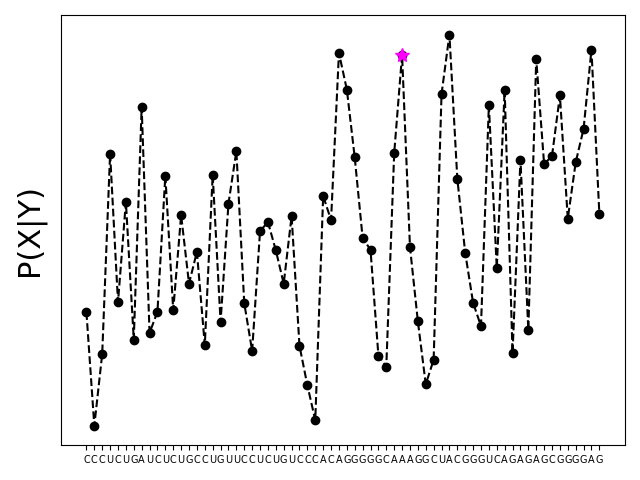

false positives:  3


In [286]:
#Neil1
loc=40

plt.figure()
plt.plot(seq_P_cond,'o--',color='black')
plt.plot(loc,np.array(seq_P_cond)[loc],'*',color='magenta',markersize=10)
plt.xticks(ticks=np.arange(len(SEQUENCEletter)),labels=SEQUENCEletter,fontsize=7)
ax = plt.gca()
plt.tick_params(left = False)
ax.axes.yaxis.set_ticklabels([])

plt.ylabel('P(X|Y)',fontsize=22)
plt.tight_layout()


plt.show()

#count false positives --> peaks higher than the RBP site probability

c=0
for p in seq_P_cond:
    
    if p >= np.array(seq_P_cond)[loc]:
        c+=1
        
print('false positives: ', c-1)

<IPython.core.display.Javascript object>


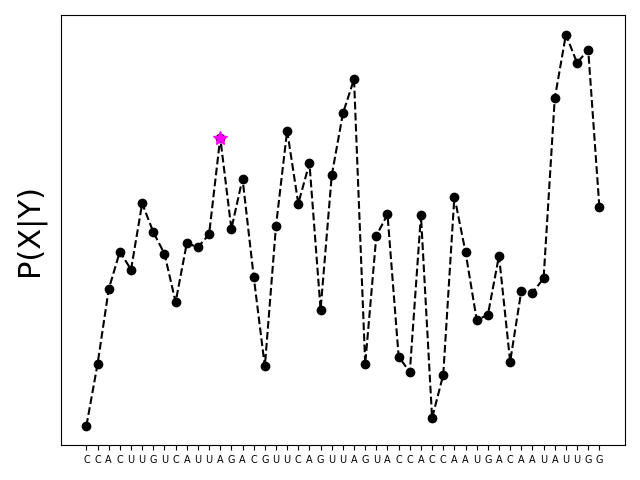

false positives:  7


In [219]:
#BDF2 
loc=12

plt.figure()
plt.plot(seq_P_cond,'o--',color='black')
plt.plot(loc,np.array(seq_P_cond)[loc],'*',color='magenta',markersize=10)
plt.xticks(ticks=np.arange(len(SEQUENCEletter)),labels=SEQUENCEletter,fontsize=7)
ax = plt.gca()
plt.tick_params(left = False)
ax.axes.yaxis.set_ticklabels([])
plt.ylabel('P(X|Y)',fontsize=22)
plt.tight_layout()


plt.show()

#count false positives --> peaks higher than the RBP site probability

c=0
for p in seq_P_cond:
    
    if p >= np.array(seq_P_cond)[loc]:
        c+=1
        
print('false positives: ', c-1)

<IPython.core.display.Javascript object>


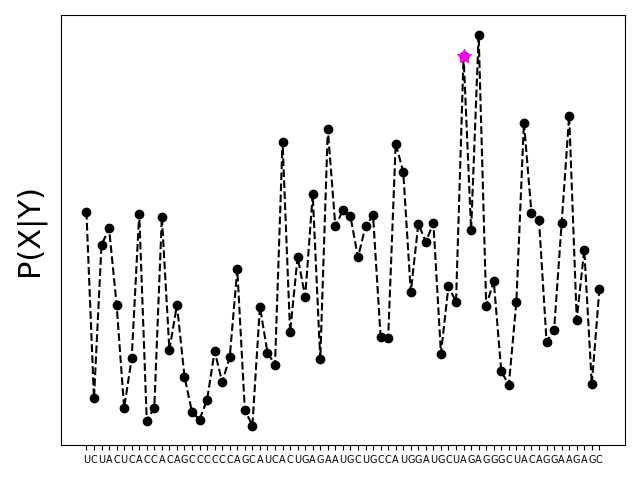

false positives:  1


In [222]:
#hGLI1
loc=50

plt.figure()
plt.plot(seq_P_cond,'o--',color='black')
plt.plot(loc,np.array(seq_P_cond)[loc],'*',color='magenta',markersize=10)
plt.xticks(ticks=np.arange(len(SEQUENCEletter)),labels=SEQUENCEletter,fontsize=7)
ax = plt.gca()
plt.tick_params(left = False)
ax.axes.yaxis.set_ticklabels([])
plt.ylabel('P(X|Y)',fontsize=22)
plt.tight_layout()


plt.show()

#count false positives --> peaks higher than the RBP site probability

c=0
for p in seq_P_cond:
    
    if p >= np.array(seq_P_cond)[loc]:
        c+=1
        
print('false positives: ', c-1)

<IPython.core.display.Javascript object>


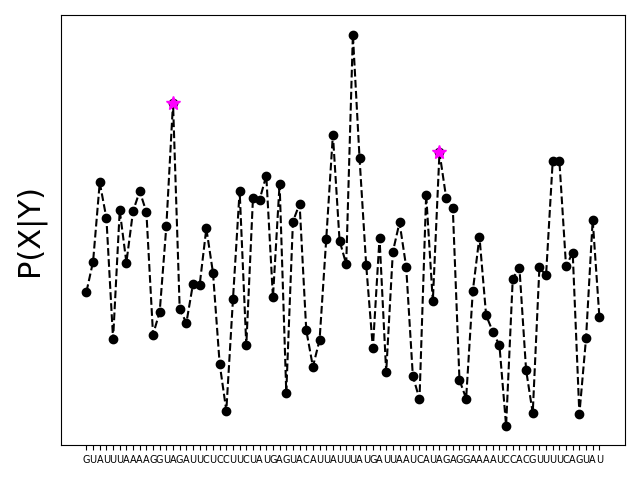

false positives:  1


In [229]:
#pri-miR
loc=13
loc2=53

plt.figure()
plt.plot(seq_P_cond,'o--',color='black')
plt.plot(loc,np.array(seq_P_cond)[loc],'*',color='magenta',markersize=10)
plt.plot(loc2,np.array(seq_P_cond)[loc2],'*',color='magenta',markersize=10)
plt.xticks(ticks=np.arange(len(SEQUENCEletter)),labels=SEQUENCEletter,fontsize=7)
ax = plt.gca()
plt.tick_params(left = False)
ax.axes.yaxis.set_ticklabels([])
plt.ylabel('P(X|Y)',fontsize=22)
plt.tight_layout()


plt.show()

#count false positives --> peaks higher than the RBP site probability

c=0
for p in seq_P_cond:
    
    if p >= np.array(seq_P_cond)[loc]:
        c+=1
        
print('false positives: ', c-1)